# Homework 6
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers K-Means and HAC methods for clustering and image segmentation.

In [1]:
# Setup
from __future__ import print_function
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import io

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

## Introduction
In this assignment, you will use clustering algorithms to segment images. You will then use these segmentations to identify foreground and background objects.

Your assignment will involve the following subtasks:
- **Clustering algorithms**: Implement K-Means clustering and Hierarchical Agglomerative Clustering.
- **Pixel-level features**: Implement a feature vector that combines color and position information and implement feature normalization.
- **Quantitative Evaluation**: Evaluate segmentation algorithms with a variety of parameter settings by comparing your computed segmentations against a dataset of ground-truth segmentations.

## 1 Clustering Algorithms (40 points)

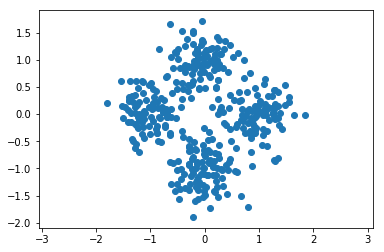

In [2]:
# Generate random data points for clustering

# Set seed for consistency
np.random.seed(0)

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Merge two sets of data points
X = np.concatenate((X1, X2, X3, X4))

# Plot data points
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

### 1.1 K-Means Clustering (20 points)
As discussed in class, K-Means is one of the most popular clustering algorithms. We have provided skeleton code for K-Means clustering in the file `segmentation.py`. Your first task is to finish implementing **`kmeans`** in `segmentation.py`. This version uses nested for loops to assign points to the closest centroid and compute a new mean for each cluster.

kmeans running time: 0.033573 seconds.


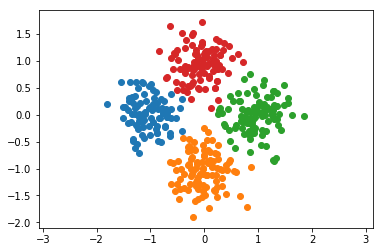

In [10]:
from segmentation import kmeans

np.random.seed(0)
start = time()
assignments = kmeans(X, 4)
end = time()

kmeans_runtime = end - start

print("kmeans running time: %f seconds." % kmeans_runtime)

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

We can use numpy functions and broadcasting to make K-Means faster. Implement **`kmeans_fast`** in `segmentation.py`. This should run at least 10 times faster than the previous implementation.

kmeans running time: 0.001411 seconds.
23.798378 times faster!


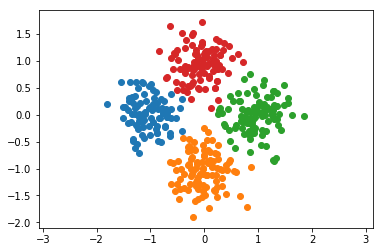

In [18]:
from segmentation import kmeans_fast

np.random.seed(0)
start = time()
assignments = kmeans_fast(X, 4)
end = time()

kmeans_fast_runtime = end - start
print("kmeans running time: %f seconds." % kmeans_fast_runtime)
print("%f times faster!" % (kmeans_runtime / kmeans_fast_runtime))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### 1.2 K-Means Convergence (10 points)
Implementations of the K-Means algorithm will often have the parameter `num_iters` to define the maximum number of iterations the algorithm should run for. Consider that we opt to not include this upper bound on the number of iterations, and that we define the termination criterion of the algorithm to be when the cost $L$ stops changing.

Recall that $L$ is defined as the sum of squared distance between all points $x$ and their nearest cluster center $c$:

$$L = \sum_{i \in clusters}\sum_{x \in cluster_i} (x - c_i)^2$$

Show that for any set of points **$D$** and any number of clusters $k$, the K-Means algorithm will terminate in a finite number of iterations.

Suppose that we have N data points to assign to k clusters. Since there are a finite number of data points and a finite number of clusters, there are a finite number of ways to assign the data points to clusters. Based on the way that the loss function is constructed, we can only re-assign points to new clusters and thus create new cluster centers $c_i$ if iteration $k$ has a loss value less than the loss value of iteration $k-1$. Otherwise, none of the points are assigned to new clusters and we do not compute new cluster center values. In other words, the loss function is a monotic decreasing function, and therefore, re-assigning a point to a new cluster cannot increase the loss from the previous iteration of the k-means algorithm. Note that if a data point is equidistant to more than one cluster center, it need not be re-assigned to a different cluster; we only re-assign a data point if we find a cluster that is closer to it than its current cluster. Once the distance to the closest cluster does not change for all of the points, the cluster centers are not changed from the previous iteration, and our algorithm terminates. The monotonic decreasing nature of our loss function, and the fact that we have a finite number of clusters and data points, suggests that we will reach a local minima, and our function will terminate in a finite number of iterations. 


### 1.2 Hierarchical Agglomerative Clustering (10 points)
Another simple clustering algorithm is Hieararchical Agglomerative Clustering, which is somtimes abbreviated as HAC. In this algorithm, each point is initially assigned to its own cluster. Then cluster pairs are merged until we are left with the desired number of predetermined clusters (see Algorithm 1).

Implement **`hiererachical_clustering`** in `segmentation.py`.

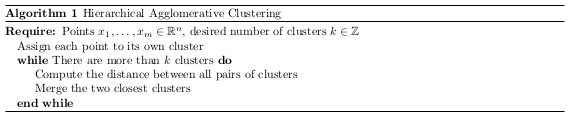

hierarchical_clustering running time: 0.002862 seconds.


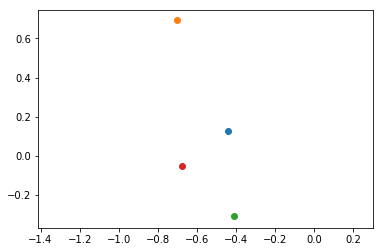

In [96]:
from segmentation import hierarchical_clustering

start = time()
assignments = hierarchical_clustering(X, 4)
end = time()

print("hierarchical_clustering running time: %f seconds." % (end - start))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

## 2 Pixel-Level Features (30 points)
Before we can use a clustering algorithm to segment an image, we must compute some *feature vector* for each pixel. The feature vector for each pixel should encode the qualities that we care about in a good segmentation. More concretely, for a pair of pixels $p_i$ and $p_j$ with corresponding feature vectors $f_i$ and $f_j$, the distance between $f_i$ and $f_j$ should be small if we believe that $p_i$ and $p_j$ should be placed in the same segment and large otherwise.

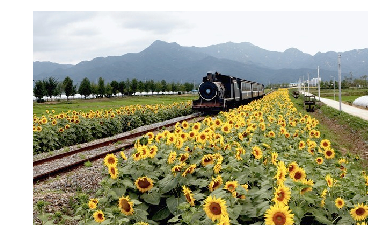

In [97]:
# Load and display image
img = io.imread('train.jpg')
H, W, C = img.shape

plt.imshow(img)
plt.axis('off')
plt.show()

### 2.1 Color Features (15 points)
One of the simplest possible feature vectors for a pixel is simply the vector of colors for that pixel. Implement **`color_features`** in `segmentation.py`. Output should look like the following:
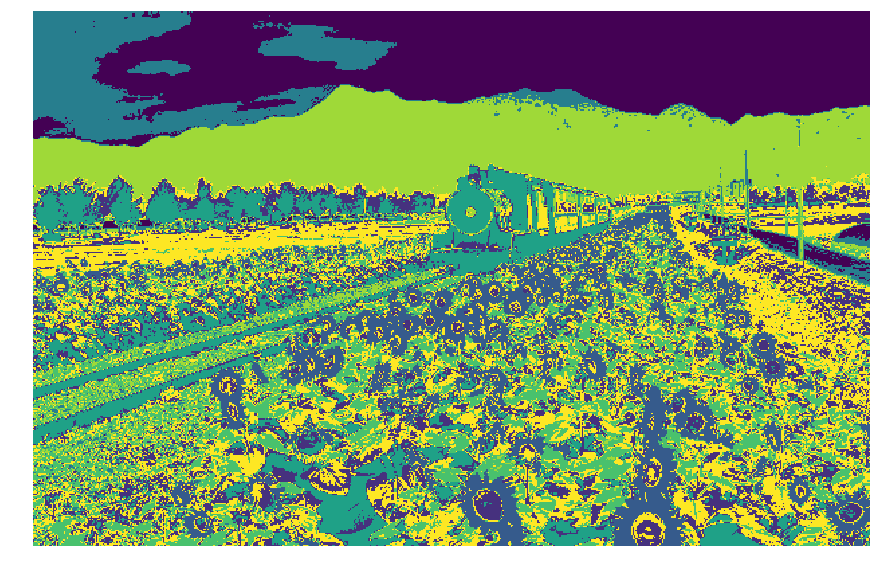

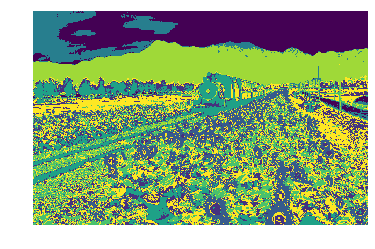

In [99]:
from segmentation import color_features
np.random.seed(0)

features = color_features(img)

# Sanity checks
assert features.shape == (H * W, C),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

In the cell below, we visualize each segment as the mean color of pixels in the segment.

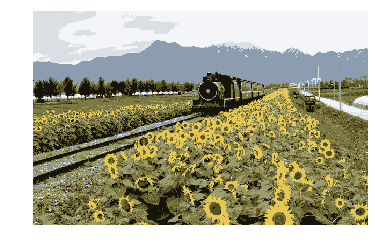

In [100]:
from utils import visualize_mean_color_image
visualize_mean_color_image(img, segments)

### 2.2 Color and Position Features (15 points)
Another simple feature vector for a pixel is to concatenate its color and position within the image. In other words, for a pixel of color $(r, g, b)$ located at position $(x, y)$ in the image, its feature vector would be $(r, g, b, x, y)$. However, the color and position features may have drastically different ranges; for example each color channel of an image may be in the range $[0, 1)$, while the position of each pixel may have a much wider range. Uneven scaling between different features in the feature vector may cause clustering algorithms to behave poorly.

One way to correct for uneven scaling between different features is to apply some sort of normalization to the feature vector. One of the simplest types of normalization is to force each feature to have zero mean and unit variance.

Implement **`color_position_features`** in `segmentation.py`.

Output segmentation should look like the following:
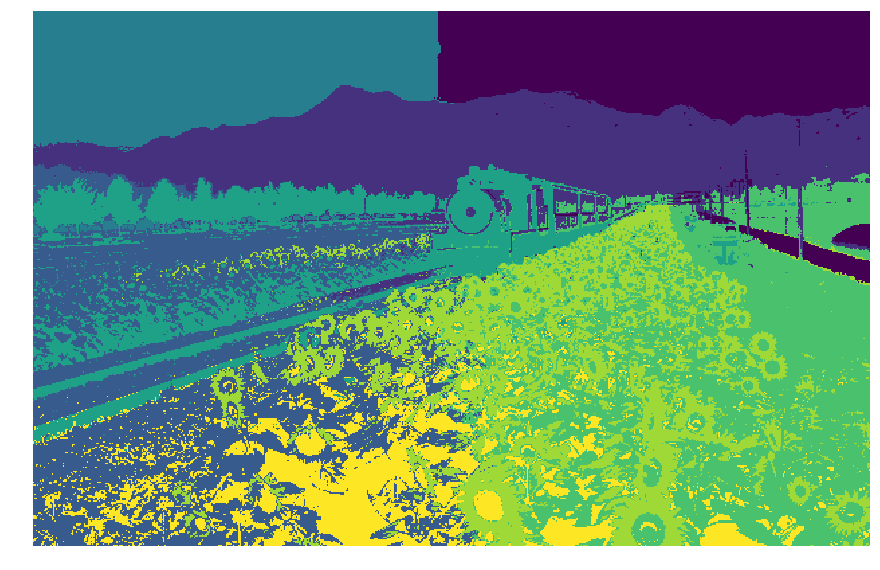

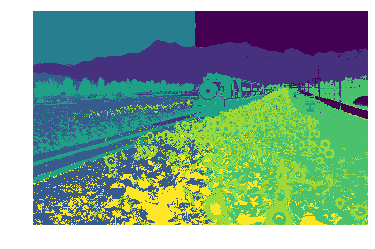

In [115]:
from segmentation import color_position_features
np.random.seed(0)

features = color_position_features(img)

# Sanity checks
assert features.shape == (H * W, C + 2),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

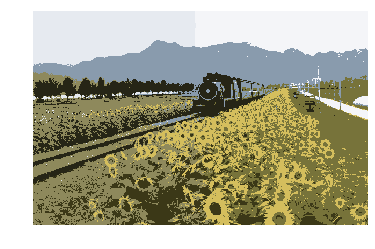

In [116]:
visualize_mean_color_image(img, segments)

### Extra Credit: Implement Your Own Feature
For this programming assignment we have asked you to implement a very simple feature transform for each pixel. While it is not required, you should feel free to experiment with other feature transforms. Could your final segmentations be improved by adding gradients, edges, SIFT descriptors, or other information to your feature vectors? Could a different type of normalization give better results?

Implement your feature extractor **`my_features`** in `segmentation.py`

Depending on the creativity of your approach and the quality of your writeup, implementing extra feature vectors can be worth extra credit (up to 1% of final grade).

**Describe your approach**: (YOUR APPROACH)

In [117]:
from segmentation import my_features

# Feel free to experiment with different images
# and varying number of segments
img = io.imread('train.jpg')
num_segments = 8

H, W, C = img.shape

# Extract pixel-level features
features = my_features(img)

# Run clustering algorithm
assignments = kmeans_fast(features, num_segments)

segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

## 3 Quantitative Evaluation (30 points)

Looking at images is a good way to get an idea for how well an algorithm is working, but the best way to evaluate an algorithm is to have some quantitative measure of its performance.

For this project we have supplied a small dataset of cat images and ground truth segmentations of these images into foreground (cats) and background (everything else). We will quantitatively evaluate different segmentation methods (features and clustering methods) on this dataset.

We can cast the segmentation task into a binary classification problem, where we need to classify each pixel in an image into either foreground (positive) or background (negative). Given the ground-truth labels, the accuracy of a segmentation is $(TP+TN)/(P+N)$.

Implement **`compute_accuracy`** in `segmentation.py`.

Accuracy: 0.97


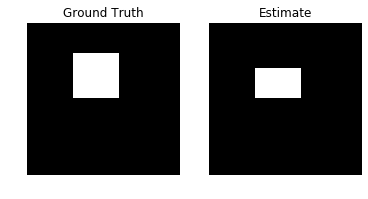

In [118]:
from segmentation import compute_accuracy

mask_gt = np.zeros((100, 100))
mask = np.zeros((100, 100))

# Test compute_accracy function
mask_gt[20:50, 30:60] = 1
mask[30:50, 30:60] = 1

accuracy = compute_accuracy(mask_gt, mask)

print('Accuracy: %0.2f' % (accuracy))
if accuracy != 0.97:
    print('Check your implementation!')

plt.subplot(121)
plt.imshow(mask_gt)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)
plt.title('Estimate')
plt.axis('off')

plt.show()

You can use the script below to evaluate a segmentation method’s ability to separate foreground from background on the entire provided dataset. Use this script as a starting point to evaluate a variety of segmentation parameters.

In [119]:
from utils import load_dataset, compute_segmentation
from segmentation import evaluate_segmentation

# Load a small segmentation dataset
imgs, gt_masks = load_dataset('./data')

# Set the parameters for segmentation.
num_segments = 3
clustering_fn = kmeans_fast
feature_fn = color_features
scale = 0.5

mean_accuracy = 0.0

segmentations = []

for i, (img, gt_mask) in enumerate(zip(imgs, gt_masks)):
    # Compute a segmentation for this image
    segments = compute_segmentation(img, num_segments,
                                    clustering_fn=clustering_fn,
                                    feature_fn=feature_fn,
                                    scale=scale)
    
    segmentations.append(segments)
    
    # Evaluate segmentation
    accuracy = evaluate_segmentation(gt_mask, segments)
    
    print('Accuracy for image %d: %0.4f' %(i, accuracy))
    mean_accuracy += accuracy
    
mean_accuracy = mean_accuracy / len(imgs)
print('Mean accuracy: %0.4f' % mean_accuracy)

/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Accuracy for image 0: 0.8081
Accuracy for image 1: 0.9592
Accuracy for image 2: 0.9670
Accuracy for image 3: 0.9047
Accuracy for image 4: 0.9740
Accuracy for image 5: 0.6844
Accuracy for image 6: 0.6714
Accuracy for image 7: 0.6690
Accuracy for image 8: 0.8373
Accuracy for image 9: 0.9535
Accuracy for image 10: 0.8478
Accuracy for image 11: 0.8113
Accuracy for image 12: 0.7325
Accuracy for image 13: 0.6628
Accuracy for image 14: 0.7439
Accuracy for image 15: 0.4984
Mean accuracy: 0.7953


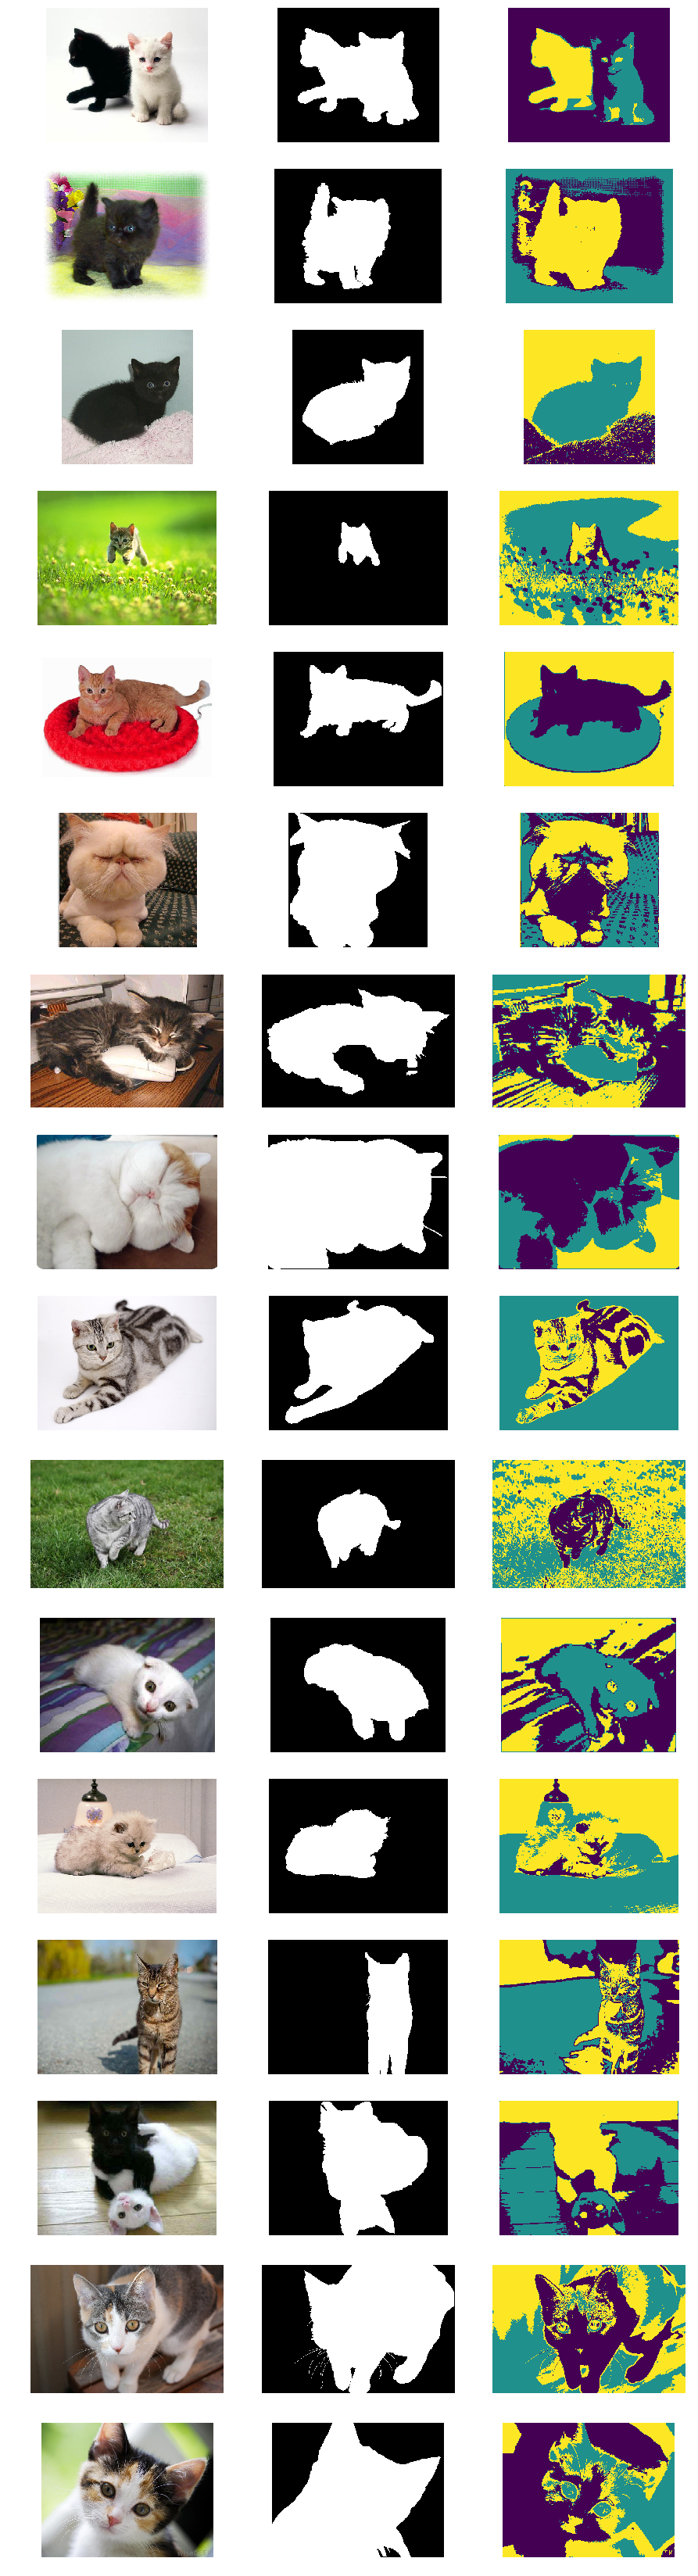

In [120]:
# Visualize segmentation results

N = len(imgs)
plt.figure(figsize=(15,60))
for i in range(N):

    plt.subplot(N, 3, (i * 3) + 1)
    plt.imshow(imgs[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 2)
    plt.imshow(gt_masks[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 3)
    plt.imshow(segmentations[i], cmap='viridis')
    plt.axis('off')

plt.show()

Include a detailed evaluation of the effect of varying segmentation parameters (feature transform, clustering method, number of clusters, resize) on the mean accuracy of foreground-background segmentations on the provided dataset. You should test a minimum of 6 combinations of parameters. To present your results, add rows to the table below (you may delete the first row).

**One tip from us** is that it's okay to avoid using hierarchical clustering altogether. The HAC algorithm is quite slow for larger scales. It is totally fine to just K-Means and modulate the other parameters of the clustering function!

In [124]:
from utils import load_dataset, compute_segmentation
from segmentation import evaluate_segmentation

# Load a small segmentation dataset
imgs, gt_masks = load_dataset('./data')

# Set the parameters for segmentation.
num_segments_list = [3, 6]
clustering_fn = kmeans_fast
feature_fns = [color_features, color_position_features]
feature_fn_names = ['Color Features', 'Color and Position Features']
scales = [0.5, 0.75, 1.0]

for feature_fn, feature_fn_name in zip(feature_fns, feature_fn_names):
    mean_accuracy = 0.0
    segmentations = []
    for scale in scales:
        for num_segments in num_segments_list:
            print('\n=========================================')
            print('Feature Function Name: ', feature_fn_name)
            print('Scale = ', scale)
            print('Number of Segments = ', num_segments)
            print('=========================================')
            for i, (img, gt_mask) in enumerate(zip(imgs, gt_masks)):
                # Compute a segmentation for this image
                segments = compute_segmentation(img, num_segments,
                                                clustering_fn=clustering_fn,
                                                feature_fn=feature_fn,
                                                scale=scale)

                segmentations.append(segments)

                # Evaluate segmentation
                accuracy = evaluate_segmentation(gt_mask, segments)

                print('Accuracy for image %d: %0.4f' %(i, accuracy))
                mean_accuracy += accuracy

            mean_accuracy = mean_accuracy / len(imgs)
            print('Mean accuracy: %0.4f' % mean_accuracy)


Feature Function Name:  Color Features
Scale =  0.5
Number of Segments =  3
Accuracy for image 0: 0.8094
Accuracy for image 1: 0.9556


/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Accuracy for image 2: 0.9680
Accuracy for image 3: 0.9047
Accuracy for image 4: 0.9724
Accuracy for image 5: 0.6837
Accuracy for image 6: 0.6721
Accuracy for image 7: 0.6632
Accuracy for image 8: 0.8427
Accuracy for image 9: 0.9536
Accuracy for image 10: 0.8498
Accuracy for image 11: 0.8113
Accuracy for image 12: 0.7325
Accuracy for image 13: 0.6537
Accuracy for image 14: 0.7439
Accuracy for image 15: 0.5050
Mean accuracy: 0.7951

Feature Function Name:  Color Features
Scale =  0.5
Number of Segments =  6
Accuracy for image 0: 0.8044
Accuracy for image 1: 0.9667
Accuracy for image 2: 0.8596
Accuracy for image 3: 0.9385
Accuracy for image 4: 0.7642


/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Accuracy for image 5: 0.5466
Accuracy for image 6: 0.6452
Accuracy for image 7: 0.4500
Accuracy for image 8: 0.7314
Accuracy for image 9: 0.8550
Accuracy for image 10: 0.7636
Accuracy for image 11: 0.8230
Accuracy for image 12: 0.8140
Accuracy for image 13: 0.7198
Accuracy for image 14: 0.6127
Accuracy for image 15: 0.5354
Mean accuracy: 0.7891

Feature Function Name:  Color Features
Scale =  0.75
Number of Segments =  3
Accuracy for image 0: 0.8098
Accuracy for image 1: 0.9586
Accuracy for image 2: 0.9851
Accuracy for image 3: 0.9086
Accuracy for image 4: 0.9737
Accuracy for image 5: 0.6623
Accuracy for image 6: 0.6636
Accuracy for image 7: 0.6708
Accuracy for image 8: 0.8372
Accuracy for image 9: 0.9516
Accuracy for image 10: 0.8722
Accuracy for image 11: 0.8106
Accuracy for image 12: 0.7370
Accuracy for image 13: 0.6523
Accuracy for image 14: 0.7450
Accuracy for image 15: 0.5049
Mean accuracy: 0.8458

Feature Function Name:  Color Features
Scale =  0.75
Number of Segments =  6
Accur

 <table style="width:100%">
  <tr>
    <th>Feature Transform</th>
    <th>Clustering Method</th>
    <th>Number of segments</th>
    <th>Scale</th>
    <th>Mean Accuracy</th>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>3</td>
    <td>0.5</td>
    <td>0.7951</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>6</td>
    <td>0.5</td>
    <td>0.7891</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-means</td>
    <td>3</td>
    <td>0.75</td>
    <td>0.8458</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-means</td>
    <td>6</td>
    <td>0.75</td>
    <td>0.7947</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-means</td>
    <td>3</td>
    <td>1.0</td>
    <td>0.8378</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-means</td>
    <td>6</td>
    <td>1.0</td>
    <td>0.8176</td>
  </tr>
  <tr>
    <td>Color and Position</td>
    <td>K-Means</td>
    <td>3</td>
    <td>0.5</td>
    <td>0.7791</td>
  </tr>
  <tr>
    <td>Color and Position</td>
    <td>K-Means</td>
    <td>6</td>
    <td>0.5</td>
    <td>0.8106</td>
  </tr>
  <tr>
    <td>Color and Position</td>
    <td>K-means</td>
    <td>3</td>
    <td>0.75</td>
    <td>0.8177</td>
  </tr>
  <tr>
    <td>Color and Position</td>
    <td>K-means</td>
    <td>6</td>
    <td>0.75</td>
    <td>0.8284</td>
  </tr>
  <tr>
    <td>Color and Position</td>
    <td>K-means</td>
    <td>3</td>
    <td>1.0</td>
    <td>0.8233</td>
  </tr>
  <tr>
    <td>Color and Position</td>
    <td>K-means</td>
    <td>6</td>
    <td>1.0</td>
    <td>0.8442</td>
  </tr>
</table> 

Observe your results carefully and try to answer the following question:
1. Based on your quantitative experiments, how do each of the segmentation parameters affect the quality of the final foreground-background segmentation?
2. Are some images simply more difficult to segment correctly than others? If so, what are the qualities of these images that cause the segmentation algorithms to perform poorly?
3. Also feel free to point out or discuss any other interesting observations that you made.

Write your analysis in the cell below.

---
In the quantitative experiments for the k-means algorithm, the segmentation parameters that I test are the feature transform, number of segments, and scale. In general, increasing the scale improves the accuracy of the algorithm. Within the color transform, we find that increasing the number of segments deteriorates the results for all scales. Within the color and position transform, we find that increasing the number of segments improves the results for all scales. Some images are more difficult to segment when a single object within the image has non-uniform lighting, creating more difficult conditions such as shadows. Overall, I think the results make sense. Increasing scaling should improve accuracy since the image quality is higher. It is interesting that increasing the number of segments caused deterioration for the color transform, but this makes sense, since it can increase the chance that one object is segmented into separate objects, especially when there is no position information encoded in the feature vector. Thus, it seems better to have the color and position transform when we choose to create more segments, because the feature vector contains position information that makes it less likely that a single object will get segmented into multiple pieces.